In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import scipy.optimize as optimization

In [13]:
class MarkowitzModel:
    def __init__(self, stocks, start_date, end_date):
        self.stocks = stocks.copy()
        self.start_date = start_date
        self.end_date = end_date
        # self.dataset = None

        # Пусть будет 100% в год (хотим удвоить).  
        # x^365 = 2, x - доходность акций
        # x = 1.00190084
        # Берём логарифм. ln(x) = 0.000824740721
        # Модель заменяет её сложную динамику на линейную модель. 
        # То есть берёём вместо x среднюю доходность и делаем вид, что она постоянно такая
        self.DOHOD = 0.000824740721
    
    def download_data(self):
        df = {}
        for stock in self.stocks:
            ticker = yf.Ticker(stock)
            df[stock] = ticker.history(start = self.start_date, end = self.end_date, period='1mo')['Close']
        return pd.DataFrame(df)
    
    def show_data(self, data):
        data.plot(figsize = (18,5))
        plt.show()

    def calculate_return(self, data):
        log_return = np.log(data / data.shift(1))
        return log_return[1:]

    def show_statistics(self, returns):
        #annual return using mean
        print(returns.mean())

        #remember covariance is matrix so it will return that
        print(returns.cov())
    
    def show_mean_variance(self, returns, weights):
        portfolio_return = np.sum(returns.mean() * weights)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights)))
        print("Expected portfolio mean(return):", portfolio_return)
        print("Expected portfolio volatility(standerd deviation):", portfolio_volatility)

    def generate_portfolios(self, returns):
        portfolio_means = []
        portfolio_risks = []
        portfolio_weights = []

        for i in range(10000):
            w = np.random.random(len(self.stocks))
            w /= np.sum(w)
            portfolio_weights.append(w)
            # returns.mean() -  среднее по одной акции на протяжении всего времени
            portfolio_means.append(np.sum(returns.mean() * w))
            portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov(), w))))

        return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)
    
    def show_portfolios(self, returns, volatilities):
        plt.figure(figsize = (18,6))
        plt.scatter(volatilities, returns, c = returns / volatilities, marker='o')
        plt.grid(True)
        plt.xlabel('Expected Volatility')
        plt.ylabel('Expected Return')
        plt.colorbar(label = 'Sharp Ratio')
        plt.show()

    def statistics(self, weights, returns):
        portfolio_return = np.sum(returns.mean() * weights)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights)))
        return np.array([portfolio_return, portfolio_volatility, portfolio_return / portfolio_volatility])

    def min_function_sharp(self, weights, returns):
        return self.statistics(weights, returns)[1]
    
    def optimize_portfolio(self, weights, returns):
        constrains = [
            {
            'type': 'eq',
            'fun': lambda x: np.sum(x) - 1
            },
            {
            'type': 'eq',
            'fun': lambda x, returns: np.sum(returns.mean() * x) - self.DOHOD, # lambda x : np.sum(x) - 1
            'args': (returns,)
            },
        ]
        #the weight can be 1 at most for single stock or weights can have value with in 0 and 1
        bounds = tuple((0, 1) for _ in range(len(self.stocks)))
        return optimization.minimize(
            fun = self.min_function_sharp,
            x0 = weights[0],
            args = returns,
            method = 'SLSQP',
            bounds = bounds,
            constraints = constrains
        )
    
    def print_optimal_portfolio(self, optimum, returns):
        print("Optimal portfolio:", optimum['x'].round(3))
        print("Expected return, volatility and sharp ratio:", self.statistics(optimum['x'].round(3), returns))

    def show_optimal_portfolios(self, opt, rets, portfolio_rets, portfolio_vols):
        plt.figure(figsize = (10,6))
        plt.scatter(
            portfolio_vols,
            portfolio_rets,
            c = portfolio_rets / portfolio_vols,
            marker='o'
        )
        plt.grid(True)
        plt.xlabel('Expected Volatility')
        plt.ylabel('Expected Return')
        plt.colorbar(label = 'Sharp Ratio')
        plt.plot(
            self.statistics(opt['x'], rets)[1],
            self.statistics(opt['x'], rets)[0],
            'g*',
            markersize = 20
        )
        plt.show()
    
    # Do all work!
    def get_optimal_weights(self, is_need_graphics = True):
        dataset = self.download_data()

        if is_need_graphics:
            self.show_data(dataset)
        log_daily_returns = self.calculate_return(dataset)
        #show_statistics(log_daily_returns)

        pweights, means, risks = self.generate_portfolios(log_daily_returns)

        if is_need_graphics:
            self.show_portfolios(means, risks)

        optimum = self.optimize_portfolio(pweights, log_daily_returns)
        self.print_optimal_portfolio(optimum, log_daily_returns)

        if is_need_graphics:
            self.show_optimal_portfolios(optimum, log_daily_returns, means, risks)

        return optimum['x'].round(3)
    
    
    def get_optimal(self, is_need_graphics = True):
        dataset = self.download_data()

        if is_need_graphics:
            self.show_data(dataset)
        log_daily_returns = self.calculate_return(dataset)
        #show_statistics(log_daily_returns)

        pweights, means, risks = self.generate_portfolios(log_daily_returns)

        if is_need_graphics:
            self.show_portfolios(means, risks)

        optimum = self.optimize_portfolio(pweights, log_daily_returns)
        self.print_optimal_portfolio(optimum, log_daily_returns)
        

In [14]:
stocks = ['AAPL', 'WMT', 'TSLA', 'GE', 'AMZN', 'DB']
start_date = '2018-01-01'
end_date = '2024-01-01'

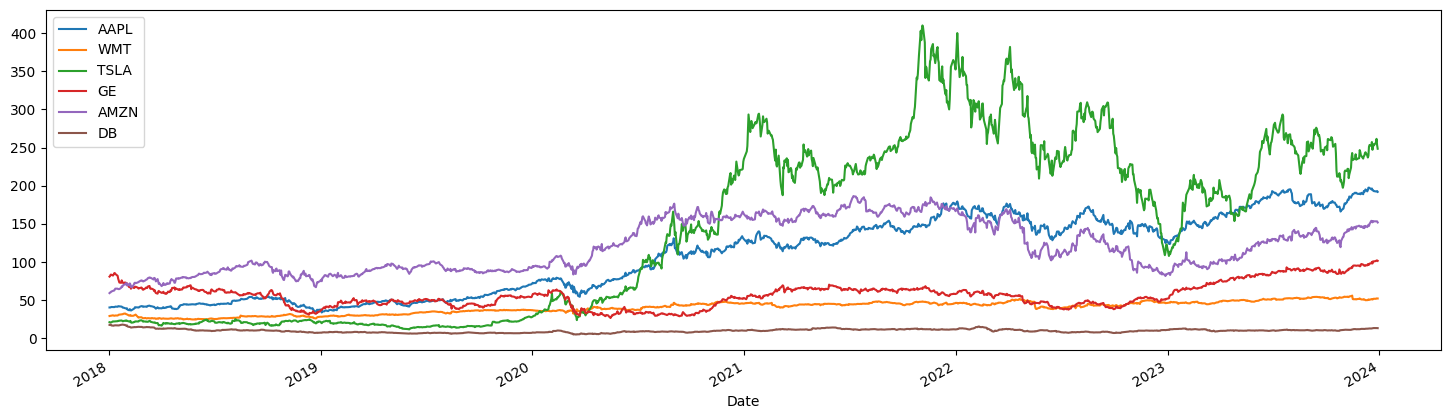

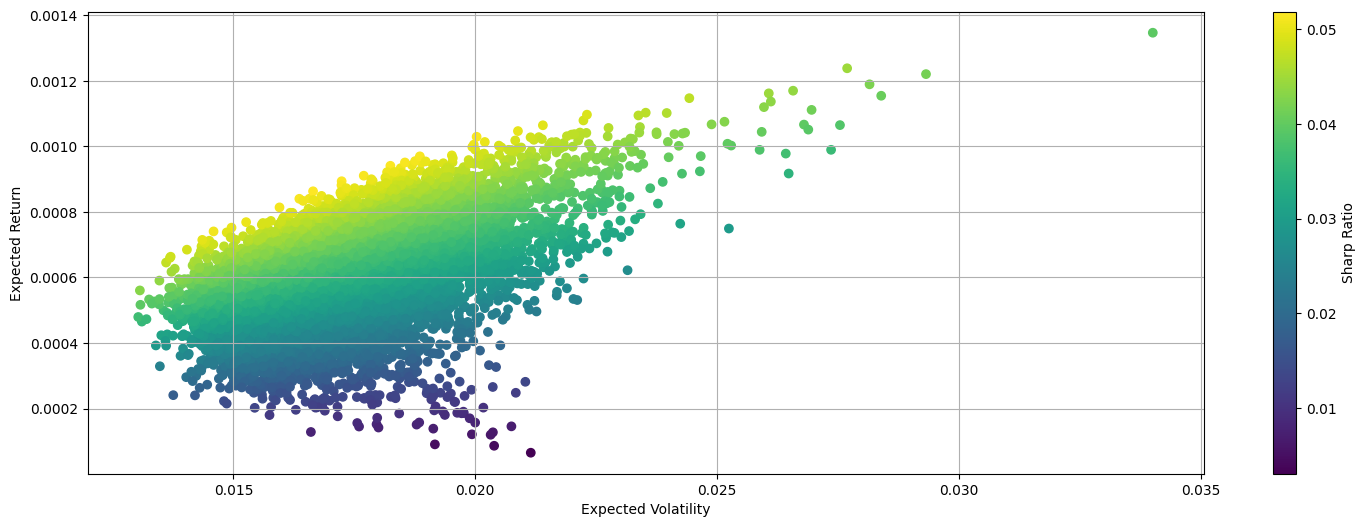

Optimal portfolio: [0.479 0.415 0.106 0.    0.    0.   ]
Expected return, volatility and sharp ratio: [0.00082441 0.01521313 0.05419047]


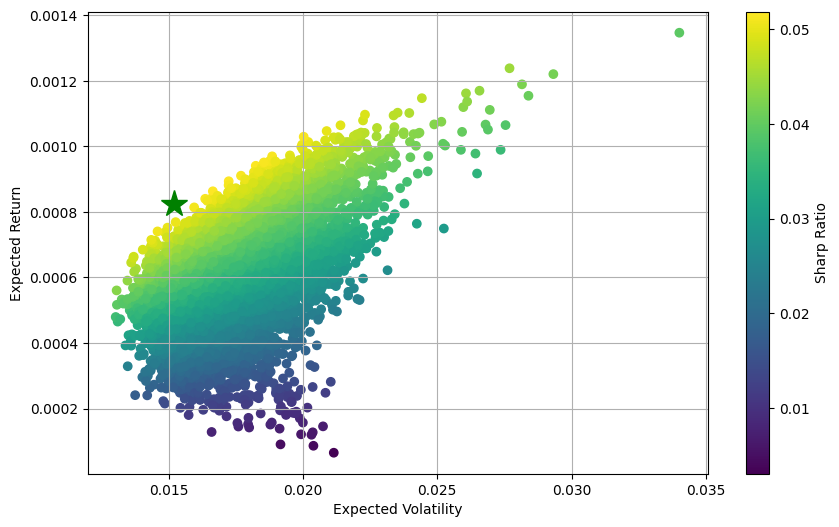

optimum =  [0.479 0.415 0.106 0.    0.    0.   ]


In [18]:
model = MarkowitzModel(stocks, start_date, end_date)
print("optimum = ", model.get_optimal_weights())

## Попытка в ребалансировку

Смотреть тут: https://readmedium.com/en/https:/python.plainenglish.io/how-to-improve-investment-portfolio-with-rebalancing-strategy-in-python-a58841ee8b5e

In [7]:
stocks = ['AAPL', 'WMT', 'TSLA', 'GE', 'AMZN', 'DB']

In [8]:
df = {}
for stock in stocks:
    ticker = yf.Ticker(stock)
    df[stock] = ticker.history(start = start_date, end = end_date, period='1mo')['Close']

df = pd.DataFrame(df)
returns = np.log(df / df.shift(1))[1:]
returns

,AAPL,WMT,TSLA,GE,AMZN,DB
Date,,,,,,
2018-01-03 00:00:00-05:00,-0.000174,0.008685,-0.010286,0.009410,0.012694,-0.008834
2018-01-04 00:00:00-05:00,0.004634,0.000904,-0.008325,0.020721,0.004466,0.031341
2018-01-05 00:00:00-05:00,0.011321,0.005910,0.006210,0.000539,0.016033,-0.063696
2018-01-08 00:00:00-05:00,-0.003721,0.014673,0.060755,-0.014123,0.014322,-0.013569
2018-01-09 00:00:00-05:00,-0.000115,-0.012079,-0.008118,0.015201,0.004665,-0.009333
...,...,...,...,...,...,...
2023-12-22 00:00:00-05:00,-0.005563,0.011880,-0.007731,-0.002208,-0.002734,0.010302
2023-12-26 00:00:00-05:00,-0.002845,-0.001533,0.015988,0.006138,-0.000065,0.005111
2023-12-27 00:00:00-05:00,0.000518,0.009355,0.018647,0.006497,-0.000456,0.002909


In [9]:
import datetime
from dateutil.relativedelta import relativedelta
import heapq

In [33]:
def portfolio(stocks, dataset, numStocks, numRev):
    selected_stocks = stocks.copy()
    
    # Будем каждый месяц делать ребалансировку. Стартовая дата - 2018-01-01. Конечная дата - 2024-01-01.
    start_month = 1
    start_year = 2018
    end_month = 1
    end_year = 2024
    curr_datetime = datetime.datetime(start_year, start_month, 1)
    next_datetime = curr_datetime + relativedelta(months=1)
    end_datetime = datetime.datetime(end_year, end_month, 1)

    i = 0
    while next_datetime + relativedelta(months=1) < end_datetime:
        next_datetime = curr_datetime + relativedelta(months=1)

        if len(selected_stocks) > 0:
            # Модель Марковица: считаем оптимальные веса для выбранных акций за месяц
            month_model = MarkowitzModel(selected_stocks, curr_datetime.strftime("%Y-%m-%d"), next_datetime.strftime("%Y-%m-%d"))
            weights = month_model.get_optimal_weights(is_need_graphics=False)

            values = np.array(weights * df[selected_stocks].iloc[i,:])
            indexes_of_max_value = heapq.nsmallest(numRev, range(len(values)), values.take)

            # убираем numRev наименее доходных акций
            selected_stocks = [stocks[ind] for ind in range(len(stocks)) if ind not in indexes_of_max_value]
        
        current_month_returns = np.array(df.iloc[i,:])
        # Добавляем ещё наиболее доходных акций в количестве numStocks - numRev.
        # Сортирую в порядке убывания по доходности за месяц
        indexes_of_max_value = heapq.nlargest(len(stocks), range(len(current_month_returns)), current_month_returns.take)
        
        # Хотим добавлять только те акции, которых еще нет в selected_stocks
        for ind in indexes_of_max_value:
            if stocks[ind] in selected_stocks:
                continue
            if len(selected_stocks) == numStocks:
                break
            selected_stocks.append(stocks[ind])


        print("From {} to {} was selected {}\n".format(
            curr_datetime.strftime("%Y-%m-%d"),
            next_datetime.strftime("%Y-%m-%d"),
            selected_stocks
        ))

        i += 1
        curr_datetime = next_datetime

    # Рассчитываем для финального месяца: просто запускаем Марковица для вычисления весов
    month_model = MarkowitzModel(selected_stocks, curr_datetime.strftime("%Y-%m-%d"), end_datetime.strftime("%Y-%m-%d"))
    weights = month_model.get_optimal_weights()
    returns = np.array(weights * df[selected_stocks].iloc[i,:])
    print("-----------------------------------------------------")
    print("------------------- Final results -------------------")
    print("Selected stock:", selected_stocks)
    print("Weights:", weights)
    print("Returns:", returns)
    print("-----------------------------------------------------")

    return weights, returns

['AAPL', 'WMT', 'TSLA', 'GE', 'AMZN', 'DB']
Optimal portfolio: [0.419 0.274 0.013 0.099 0.105 0.089]
Expected return, volatility and sharp ratio: [0.00082536 0.00601259 0.13727224]
From 2018-01-01 to 2018-02-01 was selected ['AAPL', 'WMT', 'GE', 'AMZN']

Optimal portfolio: [0.239 0.193 0.088 0.48 ]
Expected return, volatility and sharp ratio: [0.00082473 0.0184754  0.04463933]
From 2018-02-01 to 2018-03-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [-0.00156808  0.02140548 -0.07325589]
From 2018-03-01 to 2018-04-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

Optimal portfolio: [0.    0.112 0.074 0.814]
Expected return, volatility and sharp ratio: [0.00082161 0.01529443 0.05371942]
From 2018-04-01 to 2018-05-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

Optimal portfolio: [0.115 0.105 0.779 0.   ]
Expected return, volatility and sharp ratio: [0.00082516 0.00576647 0.14309671]
From 2018-05-01 to 2018-06-01 was se

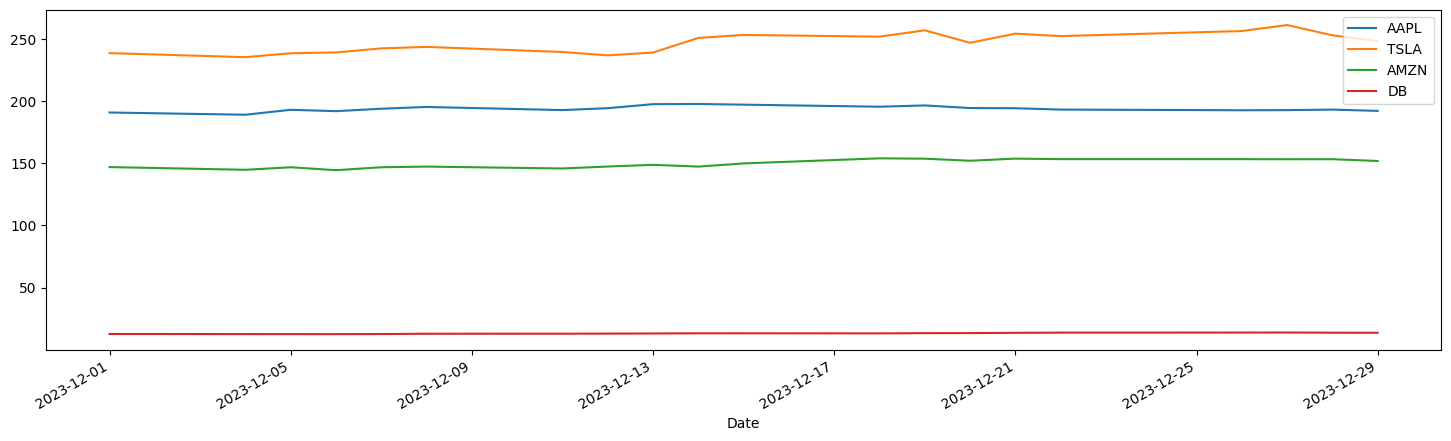

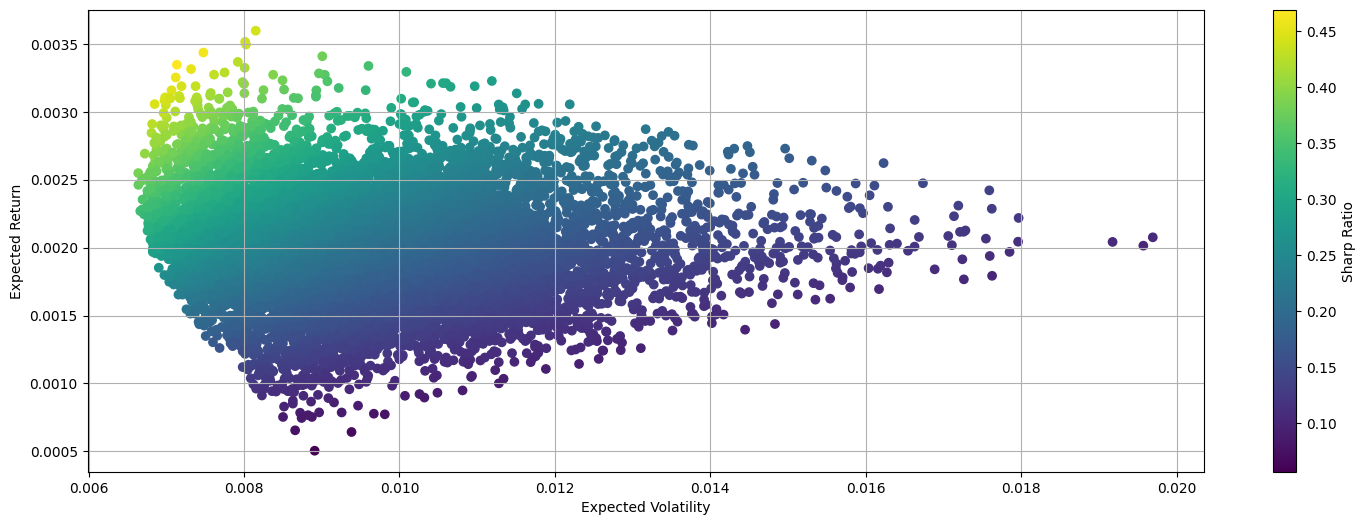

Optimal portfolio: [0.823 0.    0.07  0.106]
Expected return, volatility and sharp ratio: [0.00082219 0.00826385 0.09949186]


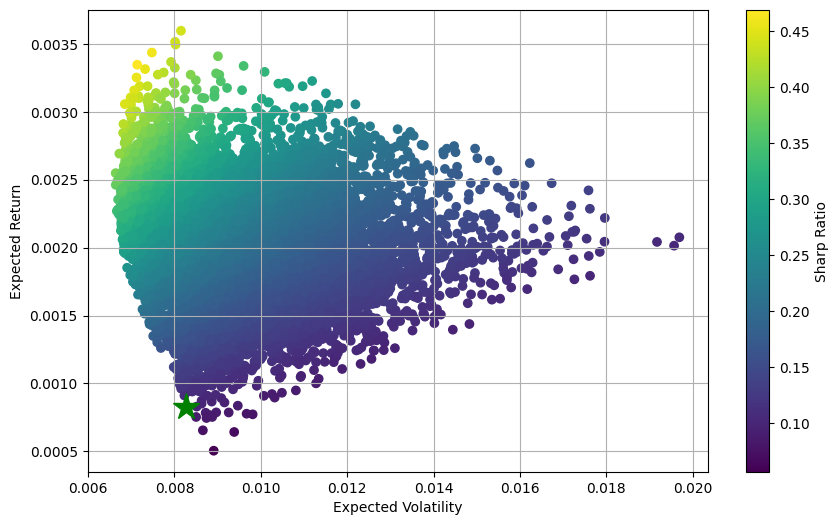

-----------------------------------------------------
------------------- Final results -------------------
Selected stock: ['AAPL', 'TSLA', 'AMZN', 'DB']
Weights: [0.823 0.    0.07  0.106]
Returns: [34.30325873  0.          5.04524979  1.40205647]
-----------------------------------------------------


In [34]:
print(stocks)
rebalanced_portfolio = portfolio(stocks, df, 4, 2)